In [85]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

## input files

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in greater
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in less


0.50288504


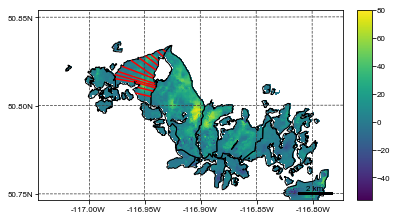

In [86]:
# season
balance = 'Ba'  # Bw or Ba (winter or annual)
# rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = 2018 # any of: 2016, 2017, 2018
I = np.abs(year - 2016) # for selecting raster inputs
vcorr=False ## is velocity corrected by off ice bias and stake bias?

gl = 1 # number to select glacier
Glacier = ['Kokanee', 'Conrad', 'Illecillewaet']
glacier = ['kokanee', 'conrad', 'illecillewaet']
d = 20. #20.  #distance (m) between flux gate points
Dint = 0.9 #depth integrated velocity ratio, 1.0= all sliding
sVZ = 4.91  #velocity against stake measurements
sHopt = 0.1 #10.3 ## ME:10.3 m,  MAE:0.223 (percent ratio)
cb = 9 ##center bin use this to assure flux in is from bins cb+1 and cb+2

fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[gl] + '/'

VDIR = 'av'  # 'average' or 'individual'

if VDIR == 'individual':  
       
    ## DEMs
    vf_list = ['img1_20160417__img1_20170521_vmap_10m_35px_spm2/', 'img1_20160417__img1_20170521_vmap_10m_35px_spm2/',
           'img1_20170904__img2_20180822_vmap_10m_35px_spm2/'] #'img1_20170521__img2_20180426_vmap_10m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/

    ##planet labs
    vf_list = ['xx', 'xx',
           'img1_20170904__img2_20180822_vmap_10m_35px_spm2/']
    
    #     vdir = '/home/pelto/Desktop/velocity_mapping/' +Glacier[gl] + '_DEMs/bedem5_spm2/' + vf_list[I]
    vdir = '/home/pelto/Desktop/velocity_mapping/conrad_planet/' + vf_list[I]
    VX = vdir+ vf_list[I][:-1] + '-F_vx.tif' 
    VY = vdir+ vf_list[I][:-1] + '-F_vy.tif' 

# # if VDIR == 'individual':  
#     vf_list = ['img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/', 'img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/',
#            'img1_20170521__img2_20180426_vmap_5.0m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/
#     vdir = '/home/pelto/Desktop/velocity_mapping/' +Glacier[gl] + '_DEMs/spm2/' + vf_list[I]
#     VX = vdir+ vf_list[I][:-1] + '-F_vx.tif' 
#     VY = vdir+ vf_list[I][:-1] + '-F_vy.tif' 
else:
#     vf_list = ['illec_all_spm2_5m', 'illec_all_spm2_5m', 'illec_all_spm2_5m']
    vdir = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/'#bedem5_spm2/'  
    VX = vdir+ 'conrad_all_vy_5m.tif' #'conrad_vx_spring_10m.tif' 
    VY = vdir+ 'conrad_all_vy_5m.tif' #'conrad_vy_spring_10m.tif'
    
## velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_10m_35px_spm2

topo = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/20160912_conrad_dem1_clip_slave.tif'
farinotti = gpr_path + 'RGI60-02.02171_thickness.tif'

dhW_list = ['conrad_2016_winter_dh_dt14s.tif', 'conrad_2017_winter_dh_dt16s.tif', 'conrad_2018_winter_dh_dt.tif']
dhA_list = ['conrad_2015_2016_dh_dt_filled_17.tif', 'conrad_2016_2017_dh_dt_filled.tif','conrad_2018_2017_dh_dt.tif']
if balance == 'Bw':
    dh_r = path+ dhW_list[I]   #winter height change TIFF
else:
    dh_r = path+  dhA_list[I] #Annual height change TIFF

pts_file = fl_path + 'conrad_points_20m_wgs84_WW.shp' #'conrad_points_17gates_20m_wgs84.shp'  ##must be WGS84 currently
gates = fl_path+'conrad_flux_gates_WW.shp'
shpf = path + Glacier[gl] + '/conrad_all_glaciers_2014.shp'  #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+glacier[gl]+'_bins_WW'+'.shp' #+str(year)

# obs_data = pd.read_csv(fl_path+ 'Conrad_bdot.csv') 
rho = pd.read_csv(fl_path + 'conrad_rho.csv')  ## rho

# open GeoTIFF as array

vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
# msk = salem.open_xr_dataset('/media/pelto/serac_backup/Lidar_DEMs/bare_earth_BC_hydro/conrad/' + 'conrad_2016_ice_msk_10m_glacieronly.tif') 
msk = salem.open_xr_dataset('/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/bedem5_spm2/conrad_2016_ice_msk_5m_glacieronly.tif') 
# msk = msk.to_array(name='msk')

gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_25_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'opt_thick_101sw_MAE_5m.tif') 
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(gates)

vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')

gpr_reproj = vx.salem.transform(gpr)
gpr = gpr_reproj.to_array(name='gpr')

msk_reproj = vx.salem.transform(msk)  #note succeeding trying to use gdalwarp to go from 2955 --> 32611
msk = msk_reproj.to_array(name='msk')

# farin = farin.to_array(name='vx')
H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')

farin_reproj= vx.salem.transform(farin)
farin = farin_reproj.to_array(name='farin')
srtm_corr = fl_path + 'conrad_SRTM_diff_30m.tif'
srtm_corr = salem.open_xr_dataset(srtm_corr)
srtm_corr = vx.salem.transform(srtm_corr)
srtm_corr = srtm_corr.to_array(name='srtm_corr')
srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
srtm_corr.data[srtm_corr.data<-50.0] = 0.0 ##remove negative anomalous values
farin_corr = farin + srtm_corr
farin_corr= farin_corr.rename('farin_corr')

gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data<1.5] = 0.0   #not having any effect
VZ = np.sqrt(vx.data**2 + vy.data**2 )
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan

VZ_off_ice = VZ.copy()
VZ_off_ice[msk.data>0.0] = np.nan
# VZ_off_ice[VZ_off_ice==0.0] = np.nan

dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

#     # map extent
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vx) #, label='m')
# sm.set_vmax(val=50.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
off_ice_V = np.nanmean(VZ_off_ice)
print(off_ice_V)

gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.savefig(fl_path+ 'products/WW/'+ glacier[gl] +'_thickness_gates.png', dpi=300)
plt.show()

## Functions for calculating zonal statistics over each flux gate bin

In [87]:
# https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
# For loading shapefiles into geopandas dataframe

def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)
 
def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
#     indices = input("Enter raster statistics selections separated by space: ")
    indices='2 3 5 6'
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats

## make an ice velocity quiver plot

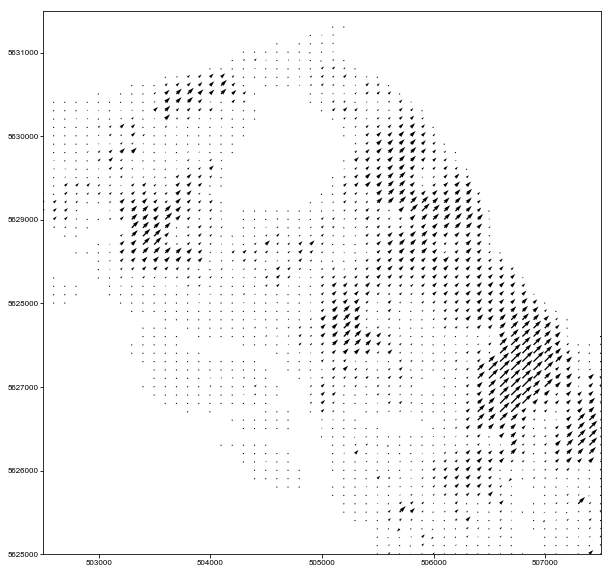

In [88]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = salem.read_shapefile(pts_file) 

df_file = loadshp_as_gpd(pts_file)
df_file.crs

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]

# ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

# shp_plt = reproject(df, VX)

X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::20, ::20], Y[::20, ::20], U[::20, ::20], V[::20, ::20], units='xy')
ax.set_xlim(502500, 507500)
ax.set_ylim( 5625000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/WW/'+ glacier[gl]+ str(year)+'_quiver.pdf', dpi=300)

# grid.ij_coordinates
# v_crs = check_crs(vx)

In [89]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem',
       'farin_corr',
       #'msk',
       ]

In [90]:
M = xr.merge([vx,vy,gpr,H_opt,dem,farin_corr]) #dem

In [91]:
df[0:4]

,len,distance,angle,ID,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y
0,211.7,0.0,123.907863,0,POINT (-116.9335438213333 50.83150514953658),-116.933544,-116.933544,50.831505,50.831505,-116.933544,50.831505,504680.072474,5.631090e+06
1,211.7,20.0,123.907863,0,POINT (-116.9333082657441 50.83140468127851),-116.933308,-116.933308,50.831405,50.831405,-116.933308,50.831405,504696.671189,5.631079e+06
2,211.7,40.0,123.907863,0,POINT (-116.9330727111665 50.83130421254361),-116.933073,-116.933073,50.831304,50.831304,-116.933073,50.831304,504713.269903,5.631068e+06
3,211.7,60.0,123.907863,0,POINT (-116.9328371576005 50.83120374333185),-116.932837,-116.932837,50.831204,50.831204,-116.932837,50.831204,504729.868618,5.631057e+06


In [92]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [93]:
df#[0:4]

,len,distance,angle,ID,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem,farin_corr
0,211.7,0.0,123.907863,0,POINT (-116.9335438213333 50.83150514953658),-116.933544,-116.933544,50.831505,50.831505,-116.933544,50.831505,504680.072474,5.631090e+06,NaN,NaN,NaN,31.342396,2017.866512,-2.675823
1,211.7,20.0,123.907863,0,POINT (-116.9333082657441 50.83140468127851),-116.933308,-116.933308,50.831405,50.831405,-116.933308,50.831405,504696.671189,5.631079e+06,-7.002424,-7.002424,NaN,39.181347,2012.637987,-1.755854
2,211.7,40.0,123.907863,0,POINT (-116.9330727111665 50.83130421254361),-116.933073,-116.933073,50.831304,50.831304,-116.933073,50.831304,504713.269903,5.631068e+06,-7.004484,-7.004484,NaN,39.181347,2009.364751,8.380970
3,211.7,60.0,123.907863,0,POINT (-116.9328371576005 50.83120374333185),-116.932837,-116.932837,50.831204,50.831204,-116.932837,50.831204,504729.868618,5.631057e+06,-3.461680,-3.461680,NaN,39.181347,2005.421918,34.488789
4,211.7,80.0,123.907863,0,POINT (-116.932601605046 50.83110327364327),-116.932602,-116.932602,50.831103,50.831103,-116.932602,50.831103,504746.467333,5.631045e+06,-0.934833,-0.934833,NaN,39.181347,2001.534914,17.220347
5,211.7,100.0,123.907863,0,POINT (-116.932366053503 50.83100280347786),-116.932366,-116.932366,50.831003,50.831003,-116.932366,50.831003,504763.066047,5.631034e+06,7.771706,7.771706,NaN,39.181347,1999.127288,19.096954
6,211.7,120.0,123.907863,0,POINT (-116.9321305029716 50.83090233283563),-116.932131,-116.932131,50.830902,50.830902,-116.932131,50.830902,504779.664762,5.631023e+06,15.013280,15.013280,NaN,40.456833,1998.268417,30.237015
7,211.7,140.0,123.907863,0,POINT (-116.9318949534518 50.83080186171659),-116.931895,-116.931895,50.830802,50.830802,-116.931895,50.830802,504796.263476,5.631012e+06,4.541799,4.541799,NaN,46.071138,1998.028819,30.125050
8,211.7,160.0,123.907863,0,POINT (-116.9316594049434 50.83070139012074),-116.931659,-116.931659,50.830701,50.830701,-116.931659,50.830701,504812.862191,5.631001e+06,-7.763444,-7.763444,NaN,48.303341,1997.432720,32.177099
9,211.7,180.0,123.907863,0,POINT (-116.9314238574467 50.83060091804807),-116.931424,-116.931424,50.830601,50.830601,-116.931424,50.830601,504829.460906,5.630990e+06,-5.256405,-5.256405,NaN,48.303341,1996.550680,33.553474


In [94]:
df_agg = df[['ID', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [95]:
# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  

In [96]:
D = df_agg[['ID', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt', 'dem', 'farin_corr']].copy()
D

,ID,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,dem,farin_corr
ij,,,,,,,,,,,,
0974_0814,8,2653.4,0.0,105.565166,-116.976357,50.817542,-1.511710,-1.511710,NaN,NaN,2579.408691,6.838911
0978_0815,8,2653.4,20.0,105.565166,-116.976084,50.817494,-3.452925,-3.452925,NaN,NaN,2578.444580,16.417019
0979_0866,9,1193.2,0.0,99.626884,-116.975979,50.815169,-0.031151,-0.031151,NaN,43.790569,2652.099365,46.278343
0982_0816,8,2653.4,40.0,105.565166,-116.975810,50.817446,1.352173,1.352173,NaN,NaN,2578.681641,30.026672
0983_0867,9,1193.2,20.0,99.626884,-116.975699,50.815139,0.468622,0.468622,NaN,43.790569,2650.422119,42.627163
0985_0817,8,2653.4,60.0,105.565166,-116.975537,50.817397,5.582903,5.582903,NaN,47.030205,2579.296875,32.300110
0987_0868,9,1193.2,40.0,99.626884,-116.975419,50.815109,0.763467,0.763467,NaN,43.790569,2650.445801,41.445614
0989_0818,8,2653.4,80.0,105.565166,-116.975263,50.817349,12.368222,12.368222,NaN,42.835640,2579.525879,40.412579
0991_0868,9,1193.2,60.0,99.626884,-116.975139,50.815079,-0.338905,-0.338905,NaN,41.497093,2648.352295,43.364826


In [97]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
# D.vzdir[D.vzdir>25.0]=np.nan  ##remove outliers for Kokanee only!!

###this step for Illec only!!
# D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone 


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.ID==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.ID==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt

KP=[]
KF=[]
# Ice flux where lowest two bins have sliding velocity equal to surface velocity
for loop in D.index:
    ID= D[D.index==loop].ID.values
    if ((ID==0) | (ID==1)):     
        KP.append( ((D[D.index==loop].vfg - off_ice_V)* (Dint+0.1) * d * D.H_opt[D.index==loop]).values[0])  
        KF.append( ((D[D.index==loop].vfg - off_ice_V)* (Dint+0.1) * d * D.farin_corr[D.index==loop]).values[0])
    else:
        KP.append((D[D.index==loop].vfg * Dint * d * D.H_opt[D.index==loop]).values[0])  ## ice flux per slice *0.9 to est. depth-integrated velocity
        KF.append((D[D.index==loop].vfg * Dint * d * D.farin_corr[D.index==loop]).values[0])
D['Qopt'] = KP
D['Qfarin'] = KF

# if vcorr==True:
#     D['Qopt'] = (D.vfg - off_ice_V + sVZ) * Dint * d * D.H_opt 
#     D['Qfarin'] = (D.vfg- off_ice_V+sVZ) * Dint * d * D.farin_corr 
#     ## ice flux per slice *0.9 to est. depth-integrated velocity
# else:
#     D['Qopt'] = (D.vfg) * Dint * d * D.H_opt 
#     D['Qfarin'] = (D.vfg) * Dint * d * D.farin_corr 

D['a'] = d * D.H_opt #area per slice
D['a_farin'] = d * D.farin_corr #area per slice

### Uncertainties
# D['sQopt'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt * D.H_opt)**2) * (D.vfg*0.9)**2) * d**2) #d=10 meters, point spacing
D['sQout'] = np.sqrt((sVZ * (D.H_opt) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.H_opt))**2)
D['sQoutF'] = np.sqrt((sVZ * (D.farin_corr) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.farin_corr))**2)

# D['sQout'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt*D.H_opt)**2) * (D.vfg*Dint)**2) * d**2)
# D['sQoutF'] = np.sqrt((sVZ**2) * ((D.farin_corr**2 + (sHopt*D.farin_corr)**2) * (D.vfg*Dint)**2) * d**2)

In [98]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]
sQout= [0.,]


for n in range(D.ID.nunique()+1):
        Q_out.append(D.Qopt[D.ID==n].sum()) 
        cr_area.append(D.a[D.ID==n].sum())
        vzdir.append(D.vzdir[D.ID==n].mean())
        sQout.append(D.sQout[D.ID==n].sum()) 
#         area_Qin.append(D.[D.ID==n].sum()) 
Q_in = [Q_out[1:]]
sQin = [sQout[1:]+ [1.0]]
# area_Qin = 
# area_Qin= 
Q_in = np.squeeze(Q_in)
sQin = np.squeeze(sQin)


Q_outF= [0.,] #flux out per gate
cr_areaF = [0.,]
sQoutF = [0.,]
for n in range(D.ID.nunique()+1):
        Q_outF.append(D.Qfarin[D.ID==n].sum()) 
        cr_areaF.append(D.a_farin[D.ID==n].sum()) 
        sQoutF.append(D.sQoutF[D.ID==n].sum())

Q_inF = [Q_outF[1:]] #flux in per bin
Q_inF = np.squeeze(Q_inF)
sQinF = [sQoutF[1:]+ [1.0]]
sQinF = np.squeeze(sQinF)

FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQout, sQin, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir)), 
        columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQin', 'Q_outF', 'Q_inF','sQoutF', 'sQinF', 'cr_areaF', 'vzdir']) 


FG.loc[cb, 'Q_in'] = FG.Q_out[cb+1]+ FG.Q_out[cb+2] #middle bin flux in 
# FG.loc[13, 'Q_in'] = 1.0 #top bin flux in 
FG.loc[cb, 'Q_inF'] = FG.Q_outF[cb+1]+ FG.Q_outF[cb+2] #middle bin flux in 

FG['vel_fg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['vel_fgF'] = FG.Q_outF / FG.cr_area
FG['bin']=np.arange(0,len(range(D.ID.nunique()+1)),1)
# FG['sQnet_opt'] = np.sqrt(FG.sQopt**2 + FG.sQin**2)

FG['spQout'] = FG.sQout / FG.Q_out * 100. #%err on flux
FG['spQin'] = FG.sQin / FG.Q_in * 100. #%err on flux
FG['spQoutF'] = FG.sQoutF / FG.Q_outF * 100. #%err on flux
FG['spQinF'] = FG.sQinF / FG.Q_inF * 100. #%err on flux

FG

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,vzdir,vel_fg,vel_fgF,bin,spQout,spQin,spQoutF,spQinF
0,0.000000e+00,3.484675e+04,0.000000,0.000000e+00,4.225183e+04,0.000000e+00,2.240251e+04,0.000000e+00,3.118156e+04,0.000000,0.000000,NaN,NaN,0,NaN,121.250432,NaN,139.187815
1,3.484675e+04,9.087420e+04,9145.749359,4.225183e+04,7.552367e+04,2.240251e+04,1.032166e+05,3.118156e+04,9.152832e+04,6140.844727,-18.000000,3.810158,2.449499,1,121.250432,83.107936,139.187815,88.675984
2,9.087420e+04,7.080817e+05,15218.881683,7.552367e+04,1.443093e+05,1.032166e+05,9.971879e+05,9.152832e+04,1.900472e+05,13750.655273,27.692308,5.971148,6.782140,2,83.107936,20.380312,88.675984,19.058310
3,7.080817e+05,1.600639e+06,26470.058060,1.443093e+05,3.940544e+05,9.971879e+05,1.961791e+06,1.900472e+05,4.645032e+05,33473.687500,45.000000,26.750288,37.672298,3,20.380312,24.618575,19.058310,23.677507
4,1.600639e+06,1.494183e+06,71796.592636,3.940544e+05,6.122579e+05,1.961791e+06,1.587685e+06,4.645032e+05,6.038560e+05,80547.632812,34.200001,22.294075,27.324288,4,24.618575,40.976111,23.677507,38.033738
5,1.494183e+06,2.835415e+06,116424.791641,6.122579e+05,1.055154e+06,1.587685e+06,2.883106e+06,6.038560e+05,1.064871e+06,114130.593750,23.906250,12.833887,13.637003,5,40.976111,37.213393,38.033738,36.934861
6,2.835415e+06,2.663601e+06,204983.312988,1.055154e+06,1.102785e+06,2.883106e+06,2.699749e+06,1.064871e+06,1.125292e+06,204684.828125,39.886364,13.832420,14.065074,6,37.213393,41.402027,36.934861,41.681339
7,2.663601e+06,2.728970e+06,213584.762802,1.102785e+06,9.207601e+05,2.699749e+06,3.015950e+06,1.125292e+06,1.038737e+06,217400.562500,27.000000,12.470932,12.640177,7,41.402027,33.740210,41.681339,34.441432
8,2.728970e+06,2.261430e+06,175282.905884,9.207601e+05,7.638128e+05,3.015950e+06,2.662399e+06,1.038737e+06,9.144574e+05,197367.578125,34.586777,15.568943,17.206187,8,33.740210,33.775659,34.441432,34.347122
9,2.261430e+06,1.831735e+06,142151.318130,7.638128e+05,2.507835e+05,2.662399e+06,2.124887e+06,9.144574e+05,3.248803e+05,170512.843750,30.789474,15.908608,18.729329,9,33.775659,13.691035,34.347122,15.289302


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

Original vector layer projection:  {'init': 'epsg:32611'}
New vector layer projection (PROJ4):  +init=epsg:32611


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:32611
New vector layer projection (PROJ4):  +init=epsg:32611


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:32611
New vector layer projection (PROJ4):  +init=epsg:32611


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


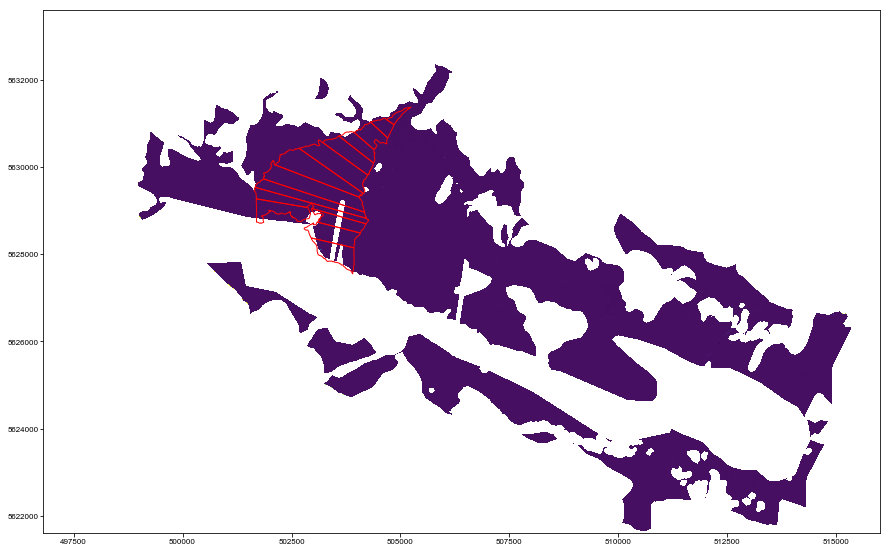

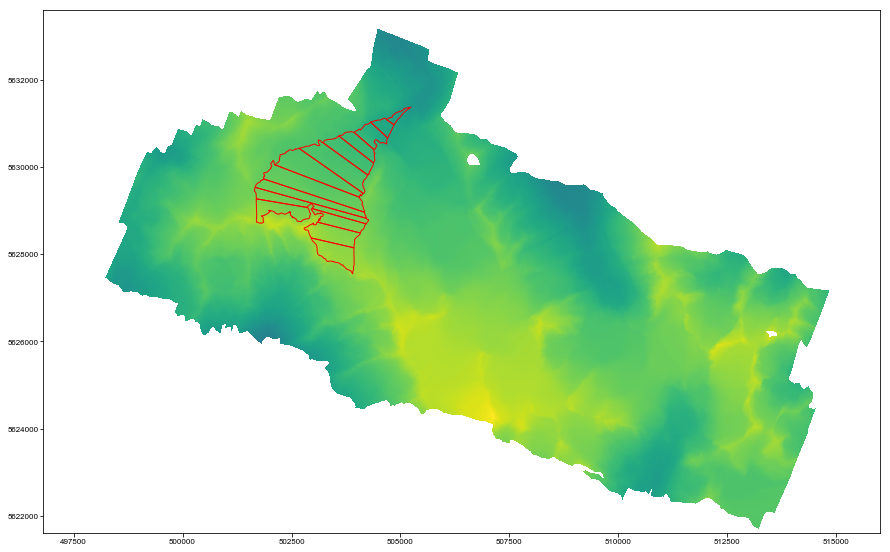

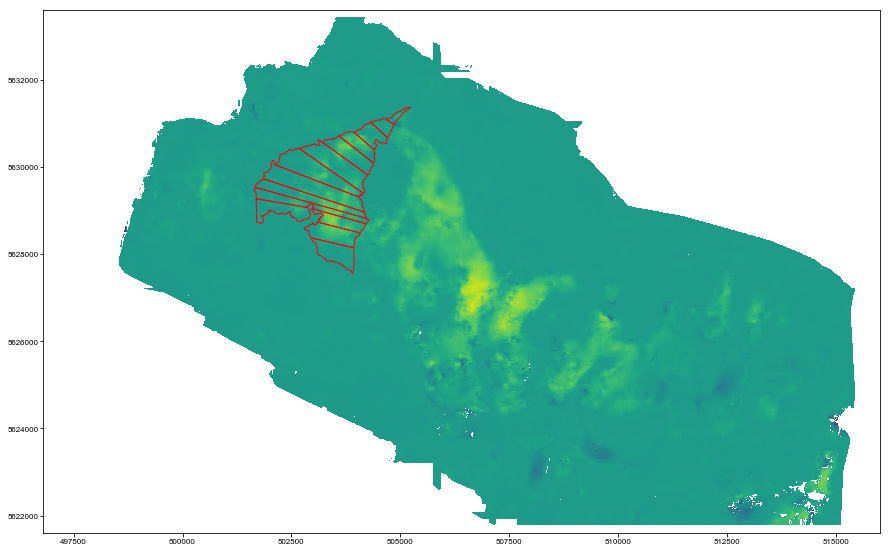

In [99]:
FG_df = FG.copy()
dem_r = topo
vel_r = VY #vdir + vf[:-1] + '-F_vm.tif'
shp = loadshp_as_gpd(bins)

rasters = [dh_r, dem_r, vel_r]
names = ['dh','dem','vy']
for i in range(len(rasters)):
    raster = rasters[i]
    rst = rasterio.open(raster)
    shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
    # dhdt= vx.salem.transform(dhdt)
    name = names[i]
#     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
    stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
    ZS = (get_zonal_stats(shp, raster, stats))
    ZS.drop(['geometry'], axis=1, inplace=True)
    ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
    ZS.sort_values(by=['bin'],ascending=True, inplace=True)
    ZS.set_index('bin', inplace=True)
    FG_df =  pd.concat([FG_df, ZS], axis=1)
    

In [100]:
rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
rho.set_index('bin', inplace=True) # set bin as index for sorting
rho[0:4]
FG_df =  pd.concat([FG_df, rho], axis=1)
FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,dem_std,vy_count,vy_mean,vy_med,vy_std,rho_2016,rho_2017,rho_2018,mean,Vfirn
0,0.000000e+00,3.484675e+04,0.000000,0.000000e+00,4.225183e+04,0.000000e+00,2.240251e+04,0.000000e+00,3.118156e+04,0.000000,...,43.040966,2389,1.266942,1.484508,5.054177,910,910,910,910.000000,0.00
1,3.484675e+04,9.087420e+04,9145.749359,4.225183e+04,7.552367e+04,2.240251e+04,1.032166e+05,3.118156e+04,9.152832e+04,6140.844727,...,18.962143,4792,3.914229,4.150337,3.240603,910,910,910,910.000000,0.00
2,9.087420e+04,7.080817e+05,15218.881683,7.552367e+04,1.443093e+05,1.032166e+05,9.971879e+05,9.152832e+04,1.900472e+05,13750.655273,...,68.283473,9159,5.935978,4.157585,7.264815,910,910,910,910.000000,0.00
3,7.080817e+05,1.600639e+06,26470.058060,1.443093e+05,3.940544e+05,9.971879e+05,1.961791e+06,1.900472e+05,4.645032e+05,33473.687500,...,13.777790,9030,17.159231,19.201361,13.487289,910,910,910,910.000000,0.00
4,1.600639e+06,1.494183e+06,71796.592636,3.940544e+05,6.122579e+05,1.961791e+06,1.587685e+06,4.645032e+05,6.038560e+05,80547.632812,...,21.253674,14782,13.091620,9.278290,13.574304,910,910,910,910.000000,0.00
5,1.494183e+06,2.835415e+06,116424.791641,6.122579e+05,1.055154e+06,1.587685e+06,2.883106e+06,6.038560e+05,1.064871e+06,114130.593750,...,26.032783,24998,7.834360,5.372147,8.187639,910,910,910,910.000000,0.00
6,2.835415e+06,2.663601e+06,204983.312988,1.055154e+06,1.102785e+06,2.883106e+06,2.699749e+06,1.064871e+06,1.125292e+06,204684.828125,...,22.985927,28862,7.438106,5.055395,8.827990,900,900,905,901.666667,0.00
7,2.663601e+06,2.728970e+06,213584.762802,1.102785e+06,9.207601e+05,2.699749e+06,3.015950e+06,1.125292e+06,1.038737e+06,217400.562500,...,27.302972,31519,9.443947,7.281011,9.768206,800,850,875,841.666667,0.11
8,2.728970e+06,2.261430e+06,175282.905884,9.207601e+05,7.638128e+05,3.015950e+06,2.662399e+06,1.038737e+06,9.144574e+05,197367.578125,...,18.295465,18635,12.042481,7.962541,13.633148,600,625,650,625.000000,0.56
9,2.261430e+06,1.831735e+06,142151.318130,7.638128e+05,2.507835e+05,2.662399e+06,2.124887e+06,9.144574e+05,3.248803e+05,170512.843750,...,21.361127,15777,10.712664,5.156194,13.486987,600,650,675,641.666667,0.20


In [101]:
WR= np.array(FG_df.dem_count[1:])
WR= np.append(WR,[0])



FG_df.loc[(cb+1), 'Q_in'] = 0.0  ## set Q_in to zero for top of west wing 

FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df.loc[cb, 'Q_net'] = FG_df.Q_out[cb+1]+ FG_df.Q_out[cb+2] - FG_df.Q_out[cb] # flux for middle bin
FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count
    
FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
FG_df.loc[cb, 'Q_netF'] = FG_df.Q_outF[cb+1]+ FG_df.Q_outF[cb+2] - FG_df.Q_outF[cb] # flux for middle bin
FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count

FG_df['area_Qin']= WR
FG_df.loc[cb, 'area_Qin'] = FG_df.dem_count[cb+1]+ FG_df.dem_count[cb+2]

FG_df['sQoptA'] = FG_df.sQout / FG_df.dem_count
FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)

FG_df['sQoutFA'] = FG_df.sQoutF / FG_df.dem_count
FG_df['sQ_inFA'] = FG_df.sQinF / (FG_df.area_Qin+0.001)
FG_df['sQnetFA'] = np.sqrt(FG_df.sQoutFA**2 + FG_df.sQ_inFA**2)


##calculate height change due to mass balance for highest bins considering firn compaction
FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

# FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
## Ilec slope, constant: (0.025293682808396056, 400.09590745271896)
FG_df['rho_snow'] = (FG_df.dem_mean*(-0.02529))+400.095  #*-0.11255+743.22)
if balance == 'Bw':
#     FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
    FG_df['b_fg_we'] = FG_df.rho_snow/1000 * FG_df.b_fg_h
else:
    FG_df['b_fg_we'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h
       
if balance == 'Bw':
#     FG_df['b_fg_weF'] = rho_snow/1000. * FG_df.b_fg_hF
    FG_df['b_fg_weF'] = FG_df.rho_snow/1000 * FG_df.b_fg_hF
else:
    FG_df['b_fg_weF'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_hF
# FG_df.drop(FG_df.tail(1).index,inplace=True)

########## test mass conservation: emergence vel + thinning = b_dot
if balance == 'Bw':
    FG_df['Bmass_con'] = (FG_df.Q_netA * FG_df.rho_snow/1000) + (FG_df.dh_mean * FG_df.rho_snow/1000) 
else:
    FG_df['Bmass_con'] = (FG_df.Q_netA * FG_df['rho_%s'%year]/1000) + (FG_df.dh_mean * FG_df['rho_%s'%year]/1000)  

if balance == 'Bw':
    FG_df['BFmass_con'] = (FG_df.Q_netAF * FG_df.rho_snow/1000) + (FG_df.dh_mean * FG_df.rho_snow/1000) 
else:
    FG_df['BFmass_con'] = (FG_df.Q_netAF * FG_df['rho_%s'%year]/1000) + (FG_df.dh_mean * FG_df['rho_%s'%year]/1000)

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQoutFA,sQ_inFA,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,Bmass_con,BFmass_con
0,0.000000e+00,3.484675e+04,0.000000,0.000000e+00,4.225183e+04,0.000000e+00,2.240251e+04,0.000000e+00,3.118156e+04,0.000000,...,0.000000,0.260337,0.260337,-3.855459,-3.647138,350.991114,-3.508468,-3.318896,-2.446778,-2.636350
1,3.484675e+04,9.087420e+04,9145.749359,4.225183e+04,7.552367e+04,2.240251e+04,1.032166e+05,3.118156e+04,9.152832e+04,6140.844727,...,0.260337,0.399809,0.477098,-3.604300,-3.811245,348.475846,-3.279913,-3.468233,-2.428560,-2.240240
2,9.087420e+04,7.080817e+05,15218.881683,7.552367e+04,1.443093e+05,1.032166e+05,9.971879e+05,9.152832e+04,1.900472e+05,13750.655273,...,0.399809,0.842094,0.932186,-2.027163,-3.236109,346.013974,-1.844719,-2.944859,3.062098,4.162238
3,7.080817e+05,1.600639e+06,26470.058060,1.443093e+05,3.940544e+05,9.971879e+05,1.961791e+06,1.900472e+05,4.645032e+05,33473.687500,...,0.842094,1.256416,1.512515,-1.641011,-1.960245,342.536403,-1.493320,-1.783823,5.704592,5.995095
4,1.600639e+06,1.494183e+06,71796.592636,3.940544e+05,6.122579e+05,1.961791e+06,1.587685e+06,4.645032e+05,6.038560e+05,80547.632812,...,1.256416,0.966035,1.584867,1.106776,1.830731,341.327033,1.007167,1.665965,0.483100,-0.175698
5,1.494183e+06,2.835415e+06,116424.791641,6.122579e+05,1.055154e+06,1.587685e+06,2.883106e+06,6.038560e+05,1.064871e+06,114130.593750,...,0.966035,1.476070,1.764088,-0.549557,-0.476267,339.538815,-0.500096,-0.433403,3.405030,3.338336
6,2.835415e+06,2.663601e+06,204983.312988,1.055154e+06,1.102785e+06,2.883106e+06,2.699749e+06,1.064871e+06,1.125292e+06,204684.828125,...,1.476070,1.427752,2.053597,0.900174,0.916173,338.289719,0.814658,0.829137,0.383587,0.369108
7,2.663601e+06,2.728970e+06,213584.762802,1.102785e+06,9.207601e+05,2.699749e+06,3.015950e+06,1.125292e+06,1.038737e+06,217400.562500,...,1.427752,2.229833,2.647760,1.385763,1.067510,336.683179,1.212543,0.934072,1.261435,1.539906
8,2.728970e+06,2.261430e+06,175282.905884,9.207601e+05,7.638128e+05,3.015950e+06,2.662399e+06,1.038737e+06,9.144574e+05,197367.578125,...,2.229833,2.318480,3.216754,2.739876,2.495179,335.459852,1.780919,1.621867,0.112164,0.271217
9,2.261430e+06,1.831735e+06,142151.318130,7.638128e+05,2.507835e+05,2.662399e+06,2.124887e+06,9.144574e+05,3.248803e+05,170512.843750,...,2.318480,0.508583,2.373607,2.613885,2.887243,334.451758,1.764372,1.948889,0.158641,-0.025875


In [102]:
### Uncertainties
sDHdt = 0.04 #m Bias dh from Pelto et al. 2019
sVfirn = 0.10
sRHO = 0.05 # percent uncertainty in density

# if FG_df.Vfirn > 0.00:
# FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnet_opt / FG_df.dem_count)**2 + (FG_df.Vfirn*sVfirn)**2) #FG_df.sQnet_opt / FG_df.dem_count
FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_df['sDH_F'] = np.sqrt(sDHdt**2 + (FG_df.sQnetFA)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_F'] = np.sqrt((FG_df.sDH_F * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_all = FG_df #.merge(FG_gpr, how='left') #on='bin')  
FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,Bmass_con,BFmass_con,sDH_opt,sBwe_opt,sDH_F,sBwe_F
0,0.000000e+00,3.484675e+04,0.000000,0.000000e+00,4.225183e+04,0.000000e+00,2.240251e+04,0.000000e+00,3.118156e+04,0.000000,...,-3.647138,350.991114,-3.508468,-3.318896,-2.446778,-2.636350,0.355024,0.355726,0.263392,0.282162
1,3.484675e+04,9.087420e+04,9145.749359,4.225183e+04,7.552367e+04,2.240251e+04,1.032166e+05,3.118156e+04,9.152832e+04,6140.844727,...,-3.811245,348.475846,-3.279913,-3.468233,-2.428560,-2.240240,0.484639,0.463537,0.478772,0.458460
2,9.087420e+04,7.080817e+05,15218.881683,7.552367e+04,1.443093e+05,1.032166e+05,9.971879e+05,9.152832e+04,1.900472e+05,13750.655273,...,-3.236109,346.013974,-1.844719,-2.944859,3.062098,4.162238,0.720628,0.656477,0.933043,0.849615
3,7.080817e+05,1.600639e+06,26470.058060,1.443093e+05,3.940544e+05,9.971879e+05,1.961791e+06,1.900472e+05,4.645032e+05,33473.687500,...,-1.960245,342.536403,-1.493320,-1.783823,5.704592,5.995095,1.243597,1.136560,1.513044,1.380890
4,1.600639e+06,1.494183e+06,71796.592636,3.940544e+05,6.122579e+05,1.961791e+06,1.587685e+06,4.645032e+05,6.038560e+05,80547.632812,...,1.830731,341.327033,1.007167,1.665965,0.483100,-0.175698,1.448114,1.318311,1.585372,1.443169
5,1.494183e+06,2.835415e+06,116424.791641,6.122579e+05,1.055154e+06,1.587685e+06,2.883106e+06,6.038560e+05,1.064871e+06,114130.593750,...,-0.476267,339.538815,-0.500096,-0.433403,3.405030,3.338336,1.760732,1.603911,1.764542,1.607374
6,2.835415e+06,2.663601e+06,204983.312988,1.055154e+06,1.102785e+06,2.883106e+06,2.699749e+06,1.064871e+06,1.125292e+06,204684.828125,...,0.916173,338.289719,0.814658,0.829137,0.383587,0.369108,2.024488,1.832407,2.053986,1.859099
7,2.663601e+06,2.728970e+06,213584.762802,1.102785e+06,9.207601e+05,2.699749e+06,3.015950e+06,1.125292e+06,1.038737e+06,217400.562500,...,1.067510,336.683179,1.212543,0.934072,1.261435,1.539906,2.422049,2.120126,2.648085,2.317837
8,2.728970e+06,2.261430e+06,175282.905884,9.207601e+05,7.638128e+05,3.015950e+06,2.662399e+06,1.038737e+06,9.144574e+05,197367.578125,...,2.495179,335.459852,1.780919,1.621867,0.112164,0.271217,2.767992,1.799601,3.217490,2.091718
9,2.261430e+06,1.831735e+06,142151.318130,7.638128e+05,2.507835e+05,2.662399e+06,2.124887e+06,9.144574e+05,3.248803e+05,170512.843750,...,2.887243,334.451758,1.764372,1.948889,0.158641,-0.025875,1.976441,1.334846,2.374028,1.603092


## Plot balance gradients

In [103]:
obs_data = pd.read_csv(fl_path+ 'Conrad_bdot.csv') 
obs=obs_data[(obs_data.Year==year)]

# obs.reset_index(inplace=True)
# T =pd.DataFrame()
# for i in range(len(obs.name)):
#     if 'W' not in obs.name[i] and 'w' not in obs.name[i] :
#         T=T.append(obs[obs.index == i],ignore_index=True)     
# obs = T

if balance == 'Bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw
else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba
x_ax_obs=obs.Elev
obs.reset_index(inplace=True)
# obs

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


slope RLM: 0.006738098838396793
slope RLM: 0.008272548663926522
slope RLM: 0.00845844799035432


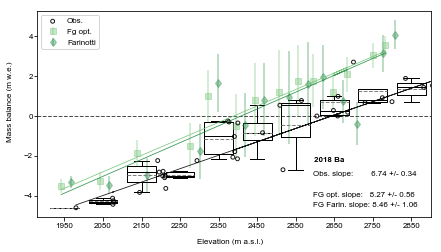

In [104]:
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.9



# Drop unrealistic FG smb:
new = FG_all.copy()

#errors (above and below)
# new['yerr'] = 0.20
yerr = [0.0, new.sBwe_opt, new.sBwe_F] #new.sBwe_gpr
new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
xerr = new.xerr 

color = ['k', '#74c476', '#238b45']
label = ['Obs.', 'Fg opt.','Farinotti']
sym = ['o', 's', 'd']

ax.scatter(obs.Elev, obs.Ba,color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3) 


### ALL points ###
x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

x_ax_fg_F=new.dem_mean  
y_ax_fg_F=new.b_fg_weF

x = [x_ax_obs, x_ax_fg_opt, x_ax_fg_F]
y = [y_ax_obs, y_ax_fg_opt, y_ax_fg_F]


# Call function to create error bars 
shift = [0,25]
for i in range(2):
    ax.errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1], fmt=sym[i+1], ecolor=color[i+1], zorder=2,
                          label=label[i+1], alpha=0.4, c=color[i+1]) #elinewidth=0.7
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])  #[0]
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, hue=color[i+1])[1]
    
## create range bar to represent flux gate elevation range
# theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
#                           elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

## plot data and regression lines

ytxt = [0.2, 0.1, 0.05]
for i in range(3):
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
#     ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
    
#     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
#     ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='Lin', alpha=a, linewidth=0.9, zorder=3)
#     print(slope, intercept, r_value, p_value, std_err)
    txt= ['Obs. slope:        ', 'FG opt. slope:   ', 'FG Farin. slope: ']
           
#     'H_{opt}''slope:$'

    #################### RLM  https://www.statsmodels.org/stable/rlm.html
    ###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
    exog = stm.add_constant(x[i]) #obs.Elev)
    rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
    rlm_results = rlm_model.fit()
    stdE=rlm_results.bse[1]
    # print(rlm_results.params)
     # ax.scatter(x[i],y[i],color=color[i], label='data', alpha=a, s=s,facecolor='', zorder=3)
    #     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
    ax.plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
            linewidth=0.8, zorder=3) # linestyle='--'
    print('slope RLM:', rlm_results.params[1])
    #############################
    ax.text(0.7, ytxt[i], txt[i]+str(np.round(1000*rlm_results.params[1],2))+ ' +/- ' + 
            str(np.round(1000*stdE,2)), transform=ax.transAxes)
    
if balance == 'Ba':
    ax.axhline(linewidth=1, color='k', ls='--', alpha=a-0.2, zorder=0)
# ax.axvline(2475.,linewidth=1, color='k', ls='--', alpha=a-0.2, zorder=0)


############ obs data box plot ################
bin_size = 100.
z_range = np.arange(1850., 2950., bin_size)
# print(z_range)
# obs['Elev_bin'] = np.nan

i = 0
# for n in range(len(obs.Ba)):

Z_F = []
Zor_F= []
OB_F=[]

for z in z_range: 
    OBS = []
    Z = []
    Zor = []
    W=0
    bin_size = 100.
    while W==0:
        for n in range(len(obs[balance])):
            if ((z - bin_size/2.) <= obs.Elev[n]) and (obs.Elev[n] <=  (z + bin_size/2.)):
                O = obs[balance][n]
                Z.append(z)
                Zor.append(obs.Elev[n])
                OBS.append(O)

        if len(OBS)<3:
            ##could select last element below elevation
            bin_size=bin_size*1.25
        else:
            OB_F.append(np.array(OBS))
            Z_F.append(np.array(Z))
            Zor_F.append(np.array(Zor))
            
            W=1
    i += 1

meanlineprops = dict(linestyle='--', linewidth=1., color='0.5')
medianprops = dict(linestyle='-', linewidth=1, color='k')
BOX=plt.boxplot(OB_F[1:],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850],widths=75)

############################
ax.set_xlim(1880,2900)
# ax.set_ylim(-8.,5.)
fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.08, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
fig.text(0.72, 0.35, str(year)+ ' '+ balance, fontweight='bold')
plt.savefig(fl_path + 'products/WW/' + Glacier[gl]+'_bdot_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

In [105]:

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

x_ax_fg_F=new.dem_mean  
y_ax_fg_F=new.b_fg_weF

x = [x_ax_obs, x_ax_fg_opt, x_ax_fg_F]
y = [y_ax_obs, y_ax_fg_opt, y_ax_fg_F]

In [106]:
new.sBwe_opt

0     0.355726
1     0.463537
2     0.656477
3     1.136560
4     1.318311
5     1.603911
6     1.832407
7     2.120126
8     1.799601
9     1.334846
10    0.878892
11    0.893807
12    0.625586
13    0.457846
Name: sBwe_opt, dtype: float64

In [107]:
new.sBwe_F
    



0     0.282162
1     0.458460
2     0.849615
3     1.380890
4     1.443169
5     1.607374
6     1.859099
7     2.317837
8     2.091718
9     1.603092
10    1.057314
11    1.072894
12    0.918360
13    0.735479
Name: sBwe_F, dtype: float64

In [108]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
# new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
# B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()
print(B_opt)
# print(B_gpr)


1.013034470839147


## Plot flux gates as cross-sections

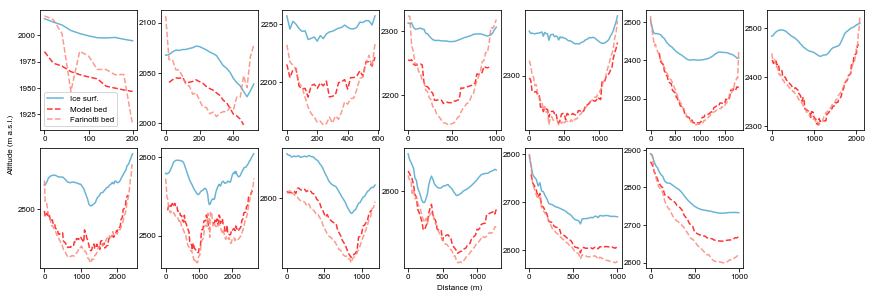

In [109]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='1'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs_H = df_agg.copy()
obs_H = obs_H.dropna(subset=['H_opt']) #, inplace=True)   

fig, ax = plt.subplots(2,7, figsize=(12,4))
for i in range(D.ID.nunique()):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.ID==i].distance, (df_agg[df_agg.ID==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
#     ax[j,k].set_ylim(((df_agg.dem[df_agg.ID==i])-(df_agg[df_agg.ID==i].farin_corr)+5).max(), -5)
    
    ##plot optimized thickness gates
    
    ax[j,k].plot(df_agg[df_agg.ID==i].distance, (df_agg[df_agg.ID==i].dem)-(df_agg[df_agg.ID==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ##plot Farinotti thickness gates
    ax[j,k].plot(df_agg[df_agg.ID==i].distance, (df_agg[df_agg.ID==i].dem)-(df_agg[df_agg.ID==i].farin_corr), 
                 ls='--', c='salmon', alpha=a, label='Farinotti bed')  #marker='o')
    ax[1,6].axis('off')
    if i == 0:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(25))
    elif i <= 2:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50))
    else:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100))
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 7: 
        j += 1
        k = 0  
         
    ax[0,0].legend(loc='best')#,  bbox_to_anchor=(0.45, -0.65),)
      
fig.text(0.002, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.04, right=0.994, wspace=0.25, hspace=0.15) 

# plt.savefig(fl_path + 'products/WW/' + glacier[gl]+'_flux_gates.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.ID_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

In [110]:
df_agg

,ID,len,distance,angle,lon,lat,i,j,vx,vy,gpr,H_opt,dem,farin_corr
ij,,,,,,,,,,,,,,
0974_0814,8,2653.4,0.0,105.565166,-116.976357,50.817542,974,814,-1.511710,-1.511710,NaN,NaN,2579.408691,6.838911
0978_0815,8,2653.4,20.0,105.565166,-116.976084,50.817494,978,815,-3.452925,-3.452925,NaN,NaN,2578.444580,16.417019
0979_0866,9,1193.2,0.0,99.626884,-116.975979,50.815169,979,866,-0.031151,-0.031151,NaN,43.790569,2652.099365,46.278343
0982_0816,8,2653.4,40.0,105.565166,-116.975810,50.817446,982,816,1.352173,1.352173,NaN,NaN,2578.681641,30.026672
0983_0867,9,1193.2,20.0,99.626884,-116.975699,50.815139,983,867,0.468622,0.468622,NaN,43.790569,2650.422119,42.627163
0985_0817,8,2653.4,60.0,105.565166,-116.975537,50.817397,985,817,5.582903,5.582903,NaN,47.030205,2579.296875,32.300110
0987_0868,9,1193.2,40.0,99.626884,-116.975419,50.815109,987,868,0.763467,0.763467,NaN,43.790569,2650.445801,41.445614
0989_0818,8,2653.4,80.0,105.565166,-116.975263,50.817349,989,818,12.368222,12.368222,NaN,42.835640,2579.525879,40.412579
0991_0868,9,1193.2,60.0,99.626884,-116.975139,50.815079,991,868,-0.338905,-0.338905,NaN,41.497093,2648.352295,43.364826
